# Fitting a distribution to simulated TC winds

Once we have simulated the wind swaths from a catalogue of TC events, we now want to examine what the probability of occurrence is for any given event. 

TCRM stores the simulated wind speed from each event at each location in the input location file, in a SQLite3 database. We can run a query on the database, and get the complete list of all events that generate high winds at a location. From that, we can demonstrate how TCRM fits an extreme value distribution to each point, to determine the return level wind speeds. 



In [1]:
%matplotlib notebook
from __future__ import print_function, division
import os
import io
import sys

import database
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import LogLocator, FormatStrFormatter
from ipywidgets import interact, fixed, Dropdown, interactive
import ipywidgets as widgets
from Utilities.config import ConfigParser

from scipy.stats import genpareto

import seaborn as sns
sns.set_context("poster")
sns.set_style("whitegrid")

We make use of some extra functions that are maintained in a separate module (I use these for working with observed wind speed data for validation of TCRM and other applications).

In [2]:
from extremes import returnLevels, empReturnPeriod, returnPeriodUncertainty, gpdSelectThreshold
from distributions import fittedPDF

Set up the configuration for the simulation. The key parts are to: 
 - set the `TrackGenerator--NumSimulations` value to match what was used in your full TCRM simulation
 - set the same `Output--Path` and 
 - set the same `Region--gridLimit` settings.
 
 

In [ ]:
configstr = """
[DataProcess]
InputFile=/home/tcrm/data/Allstorms.ibtracs_wmo.v03r09.csv
Source=IBTRACS
StartSeason=1981
FilterSeasons=False

[Region]
; Domain for windfield and hazard calculation
gridLimit={'xMin':175.,'xMax':185.,'yMin':-23.0,'yMax':-13.0}
gridSpace={'x':1.0,'y':1.0}
gridInc={'x':1.0,'y':0.5}

[TrackGenerator]
NumSimulations=10000
YearsPerSimulation=1
SeasonSeed=68876543
TrackSeed=334825
TimeStep=1.0

[Input]
landmask = /home/tcrm/tcrm/input/landmask.nc
mslpfile = /home/tcrm/tcrm/MSLP/slp.day.ltm.nc
datasets = IBTRACS,LTMSLP

[Output]
Path=/media/sf_share/tcrm/fiji

[Hazard]
Years=2,5,10,20,25,50,100,200,250,500,1000,2000,2500,5000
MinimumRecords=10
CalculateCI=False

[Logging]
LogFile=/media/sf_share/tcrm/fiji/log/fiji.log
LogLevel=INFO
Verbose=False

[IBTRACS]
; Input data file settings
url = ftp://eclipse.ncdc.noaa.gov/pub/ibtracs/v03r06/wmo/csv/Allstorms.ibtracs_wmo.v03r09.csv.gz
path = /home/tcrm//tcrm/input/
filename = Allstorms.ibtracs_wmo.v03r09.csv
columns = tcserialno,season,num,skip,skip,skip,date,skip,lat,lon,skip,pressure
fielddelimiter = ,
numberofheadinglines = 3
pressureunits = hPa
lengthunits = km
dateformat = %Y-%m-%d %H:%M:%S
speedunits = kph

[LTMSLP]
; MSLP climatology file settings
URL = ftp://ftp.cdc.noaa.gov/Datasets/ncep.reanalysis.derived/surface/slp.day.1981-2010.ltm.nc
path = /home/tcrm//tcrm/MSLP
filename = slp.day.ltm.nc

[Process]
DatFile=/media/sf_share/tcrm/fiji/process/dat/fiji.dat
ExcludePastProcessed=False
"""

config = ConfigParser()
config.readfp(io.BytesIO(configstr))

In [3]:
configFile = "/g/data/w85/TCRM_data/tcrm2.1/tcrm2.1.201805310953.ini"
config = ConfigParser()
config.read(configFile)

In [4]:
outputPath = config.get('Output', 'Path')
print(outputPath)

/g/data/w85/TCRM_data/tcrm2.1


Here, we load the database, and get a list of locations that are stored in the database. This will be used to create a dropdown so you can select the locations and automatically plot the return level curve.

In [5]:
db = database.HazardDatabase(configFile)
locations = db.getLocations()
locNameList = list(locations['locName'])
outputPath = config.get('Output', 'Path')
NumSimulations = config.getint('TrackGenerator', 'NumSimulations')

Now we define a number of functions to perform the data extraction, fitting routine and plotting...

In [79]:
from scipy.optimize import curve_fit
from scipy.stats import scoreatpercentile
import lmfit

def residual(p, x, y):
    return genpareto.pdf(x, p['xi'], loc=p['mu'], scale=p['sig']) - y

def calcSD(pars, cov, rate, npyr, intervals):
    nsims = 1000
    rps = np.zeros((nsims, len(intervals)))
    for i in range(nsims):
        xi = pars[0] + np.random.normal(0, np.sqrt(cov[0,0]))
        mu = pars[1] + np.random.normal(0, np.sqrt(cov[1,1]))
        sig = pars[2] + np.random.normal(0, np.sqrt(cov[2,2]))
        rps[i, : ] = mu + (sig / xi) * (np.power(intervals * npyr * rate, xi) - 1.)
    lowerrp = scoreatpercentile(rps, 5, axis=0)
    upperrp = scoreatpercentile(rps, 95, axis=0)
    return lowerrp, upperrp

def calculateUncertainty(wspd, intervals, xi, mu, sig):
    """
    :param wspd: :class:`numpy.array` of wind speeds
    :param float xi: initial guess for 
    """
    bins = np.arange(0.5, 100, 1)
    n, bins = np.histogram(wspd, bins, normed=True)
    centres = 0.5*(bins[1:]+bins[:-1])
    pars,cov = curve_fit(lambda x, xi, mu, sig: genpareto.pdf(x, xi, loc=mu, scale=sig), 
                         centres, n, p0=[0, np.mean(wspd), np.mean(wspd)], maxfev=10000 )
    gpd = genpareto.fit(wspd, floc=mu)
    npyr = 365.25

    p = lmfit.Parameters()
    p.add_many(('xi', gpd[0], True, -np.inf, 2.), ('mu', gpd[1]),('sig', gpd[2]))

    mini = lmfit.Minimizer(residual, p, fcn_args=(centres, n), nan_policy='omit')

    # first solve with Nelder-Mead
    out1 = mini.minimize(method='Nelder')
    out2 = mini.minimize(method='leastsq', params=out1.params)

    cmu = out2.params['mu'].value
    cxi = out2.params['xi'].value
    csig = out2.params['sig'].value
    rate = len(wspd)/(npyr*10000)
    crp = cmu + (csig / cxi) * (np.power(intervals * npyr * rate, cxi) - 1.)
    lrp, urp = calcSD((cxi, cmu, csig), out2.covar, rate, npyr, intervals)
    return crp, lrp, urp


In [54]:
class PlotUnits(object):

    def __init__(self, units):
        labels = {
            'mps': 'm/s',
            'mph': 'mi/h',
            'kts': 'kts',
            'kph': 'km/h',
            'kmh': 'km/h'
        }

        levels = {
            'mps': np.arange(30, 101., 5.),
            'mph': np.arange(80, 221., 10.),
            'kts': np.arange(60, 201., 10.),
            'kph': np.arange(80, 361., 20.),
            'kmh': np.arange(80, 361., 20.)
        }

        self.units = units
        self.label = labels[units]
        self.levels = levels[units]
        
# Set the plotting units to be metres/second
plotUnits = PlotUnits('mps')

def extractRecords(db, locId, nsimulations):
    recs = database.locationRecords(db, locId)
    data = np.zeros(int(nsimulations * 365.25))
    data[-len(recs):] = recs['wspd']

    allevents = np.sort(data)
    return allevents

def extractReturnLevel(db, locId):
    recs = database.locationAllReturnLevels(db, locId)
    return recs

def fitDistribution(db, locId, intervals, nyears):
    records = database.locationRecords(db, locId)
    recs = records['wspd']
    threshold = np.percentile(recs, 99.5)
    gpd = genpareto.fit(recs[recs > threshold], floc=threshold)
    data = np.zeros(int(nyears*365.25))
    data[-len(recs):] = recs
    rate = float(len(data[data > threshold])) / float(len(data))
    rval = returnLevels(intervals, threshold, gpd[0], gpd[2], rate)
    crp, lrp, urp = calculateUncertainty(recs, intervals, gpd[0], gpd[2], gpd[1])
    return crp, lrp, urp

def addGrid(axes):
    """
    Add a logarithmic graticule to the subplot axes.
    :param axes: :class:`axes` instance.
    """

    axes.xaxis.set_major_locator(LogLocator())
    axes.xaxis.set_major_formatter(FormatStrFormatter('%d'))
    axes.xaxis.set_minor_locator(LogLocator(subs=[.1, .2, .3, .4, .5, .6, .7, .8, .9]))
    axes.autoscale(True, axis='x', tight=True)
    axes.grid(True, which='major', linestyle='-', linewidth=0.5)
    axes.grid(True, which='minor', linestyle='-', linewidth=0.5)
    
def subplot(axes, subfigure):
    """
    Draw a line and range plot on an :class:`matplotlib.axes`
    instance, with a logarithmic scale on the x-axis. Data and
    labels are contained in a tuple. x-ticks presented as integer
    values. A grid is added with a call to
    :meth:`SemilogCurve.addGrid`.
    :param axes: :class:`matplotlib.axes` instance.
    :param tuple subfigure: Holds the data and labels to be added
                            to the subplot.
    """
    xdata, events, ydata, xlabel, ylabel, title, fit = subfigure
    rp, lrp, urp = ydata
    emprp = empReturnPeriod(events)

    axes.semilogx(xdata, rp, lw=2, subsx=xdata, 
                  label = 'Fitted hazard curve ({0})'.format(fit))
    axes.scatter(emprp[emprp > 1], events[emprp > 1], s=100,
                 color='r', label = 'Empirical ARI')
    axes.semilogx(xdata, lrp, lw=2, color='b', subsx=xdata)
    axes.semilogx(xdata, urp, lw=2, color='0.5', subsx=xdata, label="90% CI")

    axes.legend(loc = 2)

    axes.set_xlabel(xlabel)
    axes.set_ylabel(ylabel)
    axes.set_title(title)
    ylim = (0., np.max([100, np.ceil(rp.max()/10.)*10.]))
    axes.set_ylim(ylim)
    addGrid(axes)
    return axes
    
def plot(years, events, rlevel, locName, locLon, locLat, fit):
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    xlabel = 'Average recurrence interval (years)'
    ylabel = 'Wind speed (%s)'%plotUnits.label
    title = "Return period wind speeds at " + locName + ", \n(%5.1f,%5.1f)"%(locLon, locLat)
    subfigure = (years, events, rlevel, xlabel, ylabel, title, fit)
    ax = subplot(ax, subfigure)
    fig.tight_layout()
    plt.show()
    
def plotLocation(locName):
    years = np.array(config.get('Hazard', 'Years').split(',')).astype(float)
    locId = locations['locId'][locations['locName']==locName][0]
    events = extractRecords(db, locId, NumSimulations)
    rlevel = fitDistribution(db, locId, years, NumSimulations)
    locLon = locations['locLon'][locations['locId']==locId][0]
    locLat = locations['locLat'][locations['locId']==locId][0]
    plot(years, events, rlevel, locName, locLon, locLat, 'GPD')
    

<IPython.core.display.Javascript object>


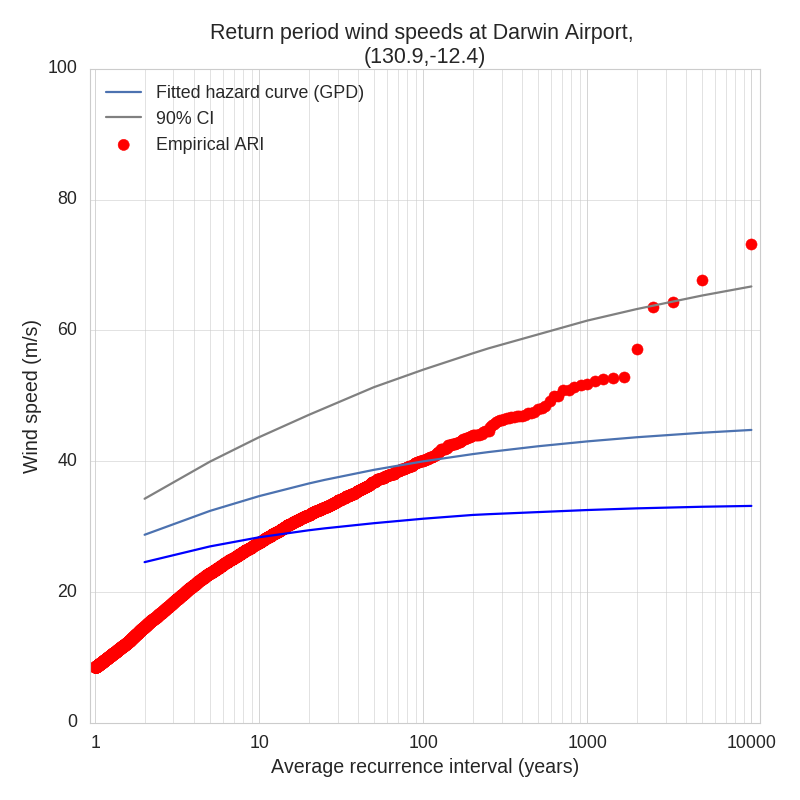

In [55]:
interactive(plotLocation, 
            locName=Dropdown(options=locNameList, description="Location"))

In [56]:
locName = "Port Hedland Airport"
locId = locations['locId'][locations['locName']==locName][0]
recs = database.locationRecords(db, locId)
wspd = recs['wspd']
wspd

array([  0.        ,   0.        ,   0.        , ...,  82.57978821,
        82.73030853,  91.06063843])

/home/547/cxa547/venv/notebooks/lib/python2.7/site-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  """Entry point for launching an IPython kernel.


<IPython.core.display.Javascript object>


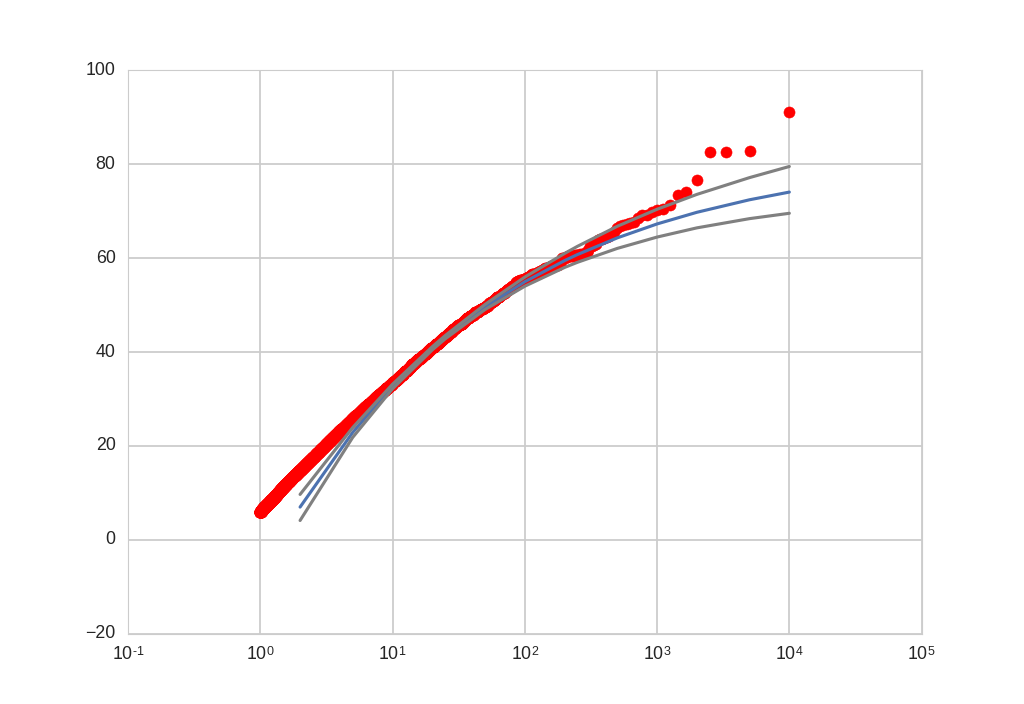

In [96]:
data = np.zeros(365.25*10000)
data[-len(wspd):] = wspd
emprp = empReturnPeriod(data)
threshold = np.percentile(wspd, 99.75)
gpd = genpareto.fit(wspd[wspd > threshold], floc=threshold)


years = np.array(config.get('Hazard', 'Years').split(',')).astype(float)
crp, lrp, urp = calculateUncertainty(wspd[wspd > threshold], years, *gpd)#[0], gpd[2], gpd[1])

fig, ax = plt.subplots(1, 1)
ax.semilogx(years, crp)
ax.semilogx(years, lrp, '0.5')
ax.semilogx(years, urp, '0.5')
ax.scatter(emprp[emprp > 1], data[emprp > 1], s=100,
                 color='r', label = 'Empirical ARI')